In [2]:
(require '[cheshire.core :as json]
         '[clojure.java.io :as io]
         '[clojure.set :refer [rename-keys]]
         '[clojure.string :as str])

nil


In [5]:
(def data (-> "resources/ranking.json"
              io/reader
              (json/parse-stream)))

#unrepl/browsable [#'user/data /5]


In [6]:
(defn keywordize-record
  [record]
  (rename-keys record {"freeze" :freeze
                       "user" :user
                       "queries" :queries}))

#unrepl/browsable [#'user/keywordize-record /6]


In [7]:
(defn split-by-query
  [record]
  (let [queries (->> record
                     :queries
                     vals
                     (mapcat keys)
                     (distinct))]
    (for [query queries]
      (assoc record :query query))))

#unrepl/browsable [#'user/split-by-query /7]


In [8]:
(defn field-score
  [field]
  (if (str/includes? field "^")
    (let [[f score] (str/split field  #"\^")]
      [(keyword f) (Integer. score)])
    [(keyword field) 1]))

#unrepl/browsable [#'user/field-score /8]


In [9]:
(defn field-str->field-map
  [s]
  (let [fields (str/split s #"\|")]
    (into {}
      (map field-score fields))))

#unrepl/browsable [#'user/field-str->field-map /9]


In [10]:
(defn split-by-fields
  [{:keys [queries query] :as record}]
  (let [new-record (dissoc record :queries)]
    (for [[field-str scores] queries]
      (-> new-record
          (assoc :fields (field-str->field-map field-str))
          (assoc :dcg (get scores query))))))

#unrepl/browsable [#'user/split-by-fields /10]


In [11]:
(def tidy-data
  (->> data
       keywordize-record
       split-by-query
       (mapcat split-by-fields)))

#unrepl/browsable [#'user/tidy-data /11]


In [12]:
(defn flatten-record
  [{:keys [fields] :as m}]
  (-> (apply merge m fields)
      (dissoc :fields)))

#unrepl/browsable [#'user/flatten-record /12]


In [30]:
(def plot
  (let [field-names (->> tidy-data
                         (map :fields)
                         (mapcat keys)
                         distinct)
        data (map flatten-record tidy-data)]

    {:$schema "https://vega.github.io/schema/vega/v5.json"
     :signals [{:name "cellSize" :value 20}
               {:name "valueWidth" :value 200}]

     :data [{:name "rawData"
             :values data}

            {:name "aggrData"
             :source "rawData"
             :transform [{:type :aggregate
                          :groupby field-names
                          :fields [:dcg :dcg]
                          :ops [:mean :stdev]
                          :as [:mean :stdev]}
                         {:type :identifier
                          :as :id}]}

            {:name "fieldNames"
             :values field-names}

            {:name "fieldData"
             :source "aggrData"
             :transform [{:type :fold
                          :fields field-names
                          :as [:field :value]}]}]

     :scales [{:name "combinations"
               :type "band"
               :domain {:data "aggrData"
                        :field :id
                        :sort {:field "mean"
                               :op :mean
                               :order :descending}}
               :range {:step {:signal "cellSize"}}}]

     :layout {:align {:row "all"
                      :column "each"}
              :padding {:row 0
                        :column 10}}

     :projections []

     :axes []

     :legends []

     :marks [{:type :group
              :name "fields"

              :scales [{:name "fields"
                        :type "band"
                        :domain field-names
                        :range {:step {:signal "cellSize"}}}

                       {:name "color"
                        :type "linear"
                        :domain {:data "fieldData"
                                 :field :value}
                        :range {:scheme "blues"}}]

              :marks [{:type :rect
                       :from {:data "fieldData"}
                       :encode {:update {:x {:scale "fields"
                                             :field :field}
                                         :y {:scale "combinations"
                                             :field :id}
                                         :width {:scale "fields"
                                                 :band 1
                                                 :offset -1}
                                         :height {:scale "combinations"
                                                  :band 1
                                                  :offset -1}
                                         :fill {:scale "color" :field :value}}}}

                      {:type :text
                       :name "columns"
                       :from {:data "fieldData"}
                       :encode {:update {:x {:scale "fields"
                                             :field :field
                                             :band 0.5}
                                         :y {:offset -2}
                                         :text {:field :field}
                                         :font {:value "sans-serif"}
                                         :fontSize {:value 10}
                                         :angle {:value -90}
                                         :align {:value :left}
                                         :baseline {:value :middle}}}}]}

             {:type :group
              :name "values"
              :encode {:enter {:width {:signal "valueWidth"}}}

              :scales [{:name "values"
                        :type :linear
                        :domain [0 1]
                        :range [0 {:signal "valueWidth"}]}]

              :marks [{:type :symbol
                       :from {:data "aggrData"}
                       :encode {:enter {:fill {:value "black"}
                                        :size {:value 40}}
                                :update {:xc {:scale "values"
                                              :field :mean}
                                         :yc {:scale "combinations" :field :id :band 0.5}}}}

                      {:type :rect
                       :from {:data "aggrData"}
                       :encode {:enter {:fill {:value "black"}
                                        :height {:value 0.5}}
                                :update {:y {:scale "combinations" :field :id :band 0.5}
                                         :x {:scale "values" :signal "datum.mean - datum.stdev"}
                                         :x2 {:scale "values" :signal "datum.mean + datum.stdev"}}}}]

              :axes [{:scale "values"
                      :orient "bottom"
                      :offset {:signal "length(data('aggrData')) * cellSize + 5"}}]}]}))

#unrepl/browsable [#'user/plot /64]


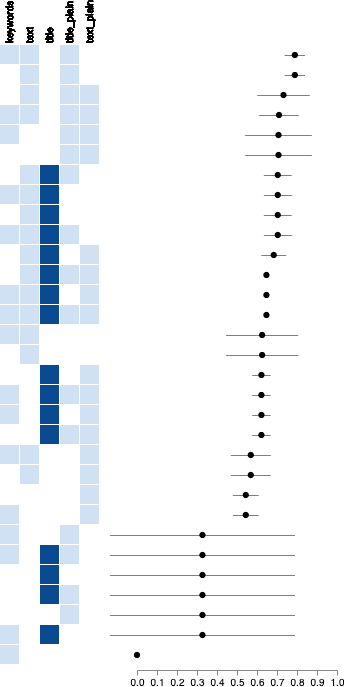

In [31]:
#unrepl/mime {:content-type "application/vnd.vega.v5+json"
              :content plot}